# Personal Finance Exploratory Data Analysis

The goal of this notebook is to explore the data extracted from Reddit's Personal Finance subreddit, including information such as the title of the submissions, the date of submission, the flair (topic), etc. Using Natural Language Processing tools and data visualization, we aim to learn any obvious and underlying trends from the submission information. In particular, we want to observe whether the data can tell us any interesting details about the users who submitted the posts such as what financial issues they may be facing. 

In [1]:
# Begin by importing the relevant libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk import word_tokenize
from nltk import PorterStemmer
import string
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import spacy
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Joshua\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_pickle(r'C:\Users\Joshua\Pickle_files\df')

In [3]:
# Import the dataframe using the pf module
df.head()

,date,id,self_text,text,time,title,topic,upvotes,clean_text,lemmatized_text,named_entities,entity_labels
0,2018-09-19,9h6whn,,Ways to make extra side money?,12:57 PM,Ways to make extra side money?,unknown,1,ways make extra side money,"[way, make, extra, side, money]",[],[]
1,2018-09-19,9h29g7,,"(Year UPDATE) Legally blind, going homeless, h...",12:56 AM,"(Year UPDATE) Legally blind, going homeless, h...",Other,16,year update legally blind going homeless one j...,"[year, update, legally, blind, go, homeless, o...",[one],[CARDINAL]
2,2018-09-19,9h6vyv,So i just found out last night the home ive be...,"19, being kicked out So i just found out last ...",12:55 PM,"19, being kicked out",Other,2,kicked found last night home ive staying going...,"[kick, find, last, night, home, have, stay, go...","[last night, returning make week]","[TIME, DATE]"
3,2018-09-19,9h6vs4,Hello! Looking for recommendations for an onli...,Online Savings Account? Hello! Looking for rec...,12:54 PM,Online Savings Account?,Saving,1,online savings account hello looking recommend...,"[online, saving, account, hello, look, recomme...",[first],[ORDINAL]
4,2018-09-19,9h6v48,,Tools for Managing Incomes and Expenses,12:52 PM,Tools for Managing Incomes and Expenses,Other,0,tools managing incomes expenses,"[tool, manage, income, expense]",[],[]


In [4]:
# Top 10 most popular topics (flairs)
df.topic.value_counts()[0:10]

Debt          2819
Other         2749
Credit        2447
Investing     1910
Retirement    1814
Employment    1688
Housing       1574
unknown       1396
Auto          1303
Planning      1229
Name: topic, dtype: int64

### Which are the most popular topics?

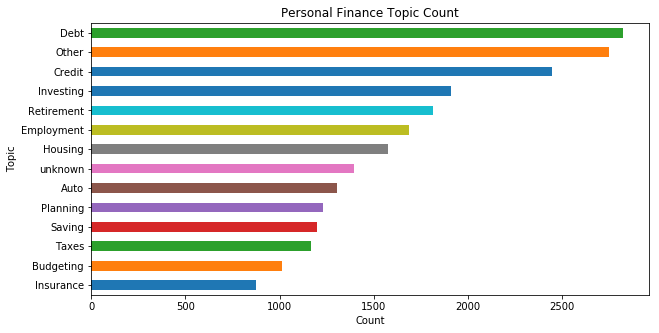

In [5]:
plt.figure(figsize = (10,5))
df.topic.value_counts()[::-1].plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Topic')
plt.title('Personal Finance Topic Count')
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Topic Count.png', bbox_inches = 'tight')
plt.show()

- Debt is the most popular topic in the personal finance subreddit, followed by Other and Credit. This indicates that debt is a major concern for many of the redditors (users) and they make submissions in order to seek advice.

- Other would include topics that don't match the default topics. With more data, it could be possible that Other is the most popular topic instead of Debt.

- Investment and Retirement are also similar in their counts while also being very similar in their functions.

- Let's look at the top 10 most popular submissions by sorting them by the number of upvotes.

In [6]:
# Top 10 most popular headlines
[title for title in df.sort_values(by='upvotes', ascending=False)['title'].values[:10]]

["IRS will allow employers to match their employees' student loan repayments",
 "If you can't get your emergency fund to grow because of emergencies that keep coming up, you're still doing a good job.",
 'Your amazon store card is probably scamming you',
 'A story of how I just got out of paying a $1500 bill, why you should NEVER blindly trust a Debt collection agency, and ALWAYS request proof of a Debt owed. ðŸ˜‚ðŸ˜‚ðŸ˜‚',
 'Girlfriend had some standard medical tests done. The clinic apparently waited too long to bill her insurance company and insurance is declining to pay them. Now, the clinic is trying to bill girlfriend for full amount and threatening to go to collections. What are her options?',
 "If the only reason you pay for Amazon Prime is because of 2-day shipping, there is a good chance it's a smarter financial move for you to cancel it than continue.",
 'So I fell for a scam yesterday and it still angers me.',
 'Credit freezes are now free. Starting today.',
 "I'm 18 and I 

- There are a variety of different subjects in the top 10 most popular posts, ranging from scams to dealing with the loss of a family member.

- However, 3 of the top 10 include the word "scam", showing that this may be a popular subject in /r/personalfinance and could happen often. This could be a common issue among many people living in the US.

- While some posts are seeking advice, others provide advice such as '"Hidden" costs of buying a home and how to prepare for them.'

- Next let's use the tokenized data and extract key words from the 20 most popular submissions. 

### Which are the most frequent tokens?

In [7]:
# Create a pandas series of the tokens by count
all_words = pd.Series(np.concatenate(df['lemmatized_text'])).value_counts()

# Import stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = set(stopwords)

# Pre-processing the data 
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]
all_words = all_words[[word for word in all_words.index if len(word)>2]]

In [8]:
all_words[:10].index

Index(['pay', 'get', 'year', 'would', 'credit', 'month', 'loan', 'money',
       'make', 'card'],
      dtype='object')

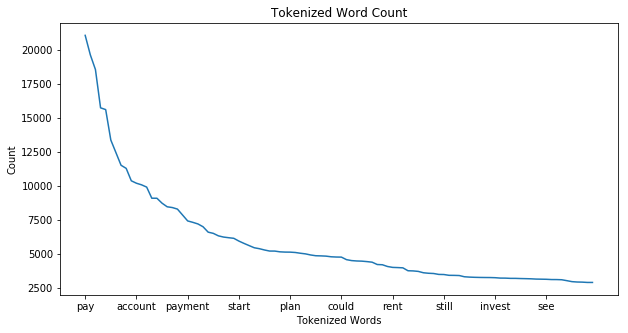

In [9]:
# Create a list of words evenly spread out by 10 in the top 100.
x = np.arange(0,100,10)
ten_words_list = []
for a in x:
    ten_words_list.append(all_words.index[a])

# Plot the words.
plt.figure(figsize = (10,5))
all_words[:100].plot()
plt.xticks(np.arange(0,100, 10), ten_words_list)
plt.xlabel('Tokenized Words')
plt.ylabel('Count')
plt.title('Tokenized Word Count')
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Token Count.png', bbox_inches = 'tight')
plt.show()

- The word 'pay' has been used over 20,000 times in the corpus of text. After the first 10 tokens, the frequency that a word is used decreases very quickly. The words 'account' and 'payment' are also fairly common and transferable among many different topics which is why it is logical for them to have high counts. Towards the end of the graph, we can start to see more topic-specific words such as 'rent' and 'invest'.

### /r/personalfinance Time Series Analysis

First let's take a look at the number of posts for /r/personalfinance by date!

Note: We will be excluding the first (August 26 2018) and last (October 20 2018) dates since they may be missing some posts.

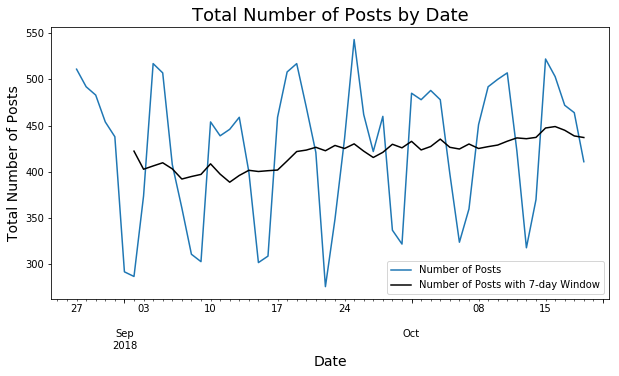

In [97]:
# Convert dates into datetime format
df.date = pd.to_datetime(df.date, format = '%Y-%m-%d')

plt.figure(figsize=(10,5))
df.groupby('date')['id'].count()[1:-1].plot()
df.groupby('date')['id'].count()[1:-1].rolling(window=7).mean().plot(color='black')
plt.legend(['Number of Posts','Number of Posts with 7-day Window'])
plt.xticks(rotation=0)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Total Number of Posts', fontsize = 14)
plt.title('Total Number of Posts by Date', fontsize=18)
plt.show()

- Right off the bat, we can see that there are many peaks and troughs. However, there is also a weekly pattern where the number of posts is usually at its lowest at the start of the week (Sunday), gradually increases and peaks in the middle of the week (Wednesday) and finally decreases until it forms another trough on Saturday. 

- This up-down pattern can perhaps be explained by the fact that people are usually more interested in doing other things during the weekends rather than posting on the internet about their personal financial issues.

- The 7-day rolling window shows that while this up-down pattern continues to emerge over the 2 months, it is overall gradually increasing.

- The most number of posts in a single day within this timeframe was 543 on September 25th while the fewest number of posts was 276 on September 22nd, just 3 days prior to the peak. 

Next, let's take a look at the total number of upvotes for /r/personalfinance posts by date.

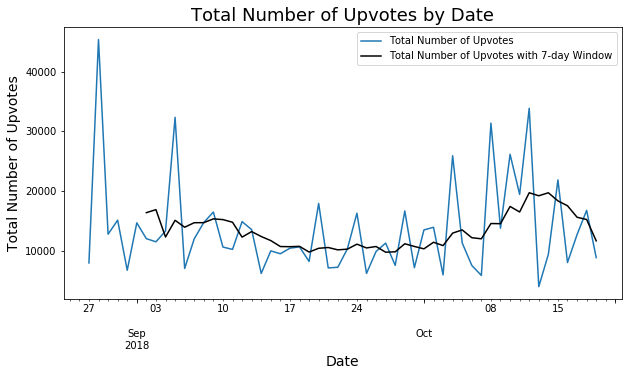

In [98]:
plt.figure(figsize=(10,5))
df.groupby('date')['upvotes'].sum()[1:-1].plot()
#df.groupby('date')['upvotes'].median().plot()
df.groupby('date')['upvotes'].sum()[1:-1].rolling(window=7).mean().plot(color='black')
plt.legend(['Total Number of Upvotes','Total Number of Upvotes with 7-day Window'])
plt.xticks(rotation=0)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Total Number of Upvotes', fontsize = 14)
plt.title('Total Number of Upvotes by Date', fontsize=18)
plt.show()

- The number of upvotes widely varies from day to day. There isn't a consistent pattern because there are many peaks and valleys through the weeks.

- The highest number of upvotes in the date range between August 26th and October 20th was on August 28th, when it hit over 45,000 total upvotes. This is in contrast to October 13th, when it only hit 4008 total upvotes. Despite only a week of difference, they were polar opposites in terms of results.

- The main takeaway from this plot is that the date does not seem to affect the total number of upvotes that the subreddit receives.

### What does the distribution of the title length look like?

In [12]:
# Create new column for text length
df['text_len'] = df['text'].apply(lambda x: len(x) - x.count(' '))

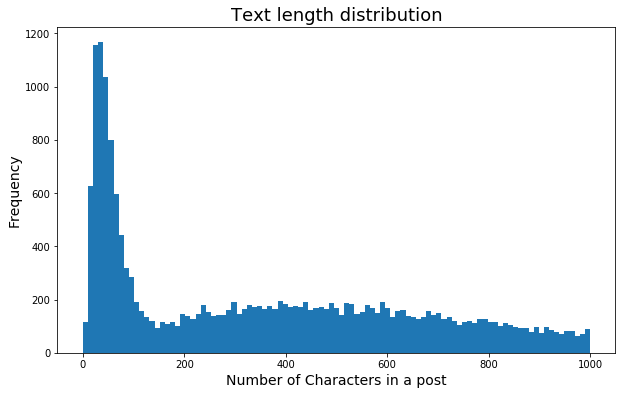

In [107]:
bins = np.linspace(0,1000,100)
plt.figure(figsize=(10,6))
plt.hist(df['text_len'], bins)
plt.title('Text length distribution', fontsize = 18)
plt.xlabel('Number of Characters in a post', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Text Length Distribution.png', bbox_inches = 'tight')
plt.show()

- As we can see, the histogram of the distribution of the text length is abnormally right-skewed with a strong kurtosis. While the graph peaks around 75-100 characters, it is difficult to tell where the mean of the data is if we only look at the graph. In reality, the mean number of characters for the posts is 602, which is far from the peak of the data. There is a strong peak but after about 150 words is a very flat-lined distribution where it gradually increases up until 600 and then begins to decline.

- One interpretation of this graph can be that there are many new users who simply want to ask a quick question without going into much detail. For example, a person may want to ask about whether they should get a Visa or MasterCard credit card. These types of posts are very common where people do not have to adequately describe their financial situation to get advice.

- Another interpretation is that many of the posts get deleted, resulting in the self-text disappearing and significantly reducing the number of characters in the total text. This is certainly plausible because of how many subscribers /r/personalfinance has. The more popular a subreddit becomes, the more common it is for new users to disregard the subreddit's rules and consequently, a higher chance that a moderator removes their post. In fact, the mean number of characters for posts under the 'unknown' topic (which is for posts that have been deleted or removed) is 130, which is well below the average of 602.

- Next, let's observe the distribution of the title lengths according to topic.

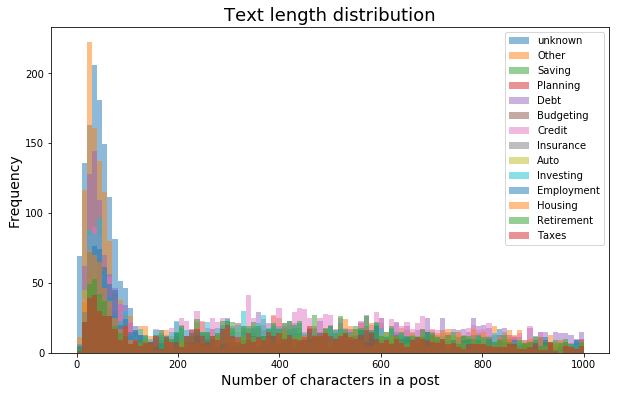

In [108]:
unique_topics = [x for x in df['topic'].unique() if x == x]

bins = np.linspace(0,1000,100)

plt.figure(figsize=(10,6))
for topic in unique_topics:
    plt.hist(df[df['topic']==topic]['text_len'], bins, alpha = 0.5,  label = topic)
plt.legend()
plt.title('Text length distribution', fontsize = 18)
plt.xlabel('Number of characters in a post', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Text Length Distribution1.png', bbox_inches = 'tight')
plt.show()

- We can see depending on the topic, the kurtosis of the histogram can vary greatly. For example, the histograms for 'Other' and 'unknown' have much heavier weight on their tails compared to the other topics such as 'Budgeting', which is appears very flat. Besides their peaks, the histograms look very similar to one another which means that outside of 'unknown', the topics have very similar distributions.

### Most popular tokens by POS (Part-of-Speech) Tagging

Part of Speech tagging is marking a word based on its __[part of speech](https://en.wikipedia.org/wiki/Part_of_speech)__. Examples can include noun, verb, and pronoun. It was initially done by hand (ex. [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus)) but there are now many different algorithms that can be used to decipher a POS tag for any given document. spaCy is a python library that has one such algorithm that allows us to obtain the POS for a given word. Let's take advantage of this by extracting singular and plural nouns from each document. 

In [15]:
# Load the tokenization model
nlp = spacy.load('en_core_web_sm')

def create_tokens(text):
    doc = nlp(text)
    tokens = [token for token in doc]
    return tokens

# Create a new tokenized_text column that contains a spaCy token object for each word
df['tokenized_text'] = df['clean_text'].apply(lambda x: create_tokens(x))

# Create function that returns the Part-of-Speech tag for each token 
def pos_tag(token_list):
    pos_list = [x.tag_ for x in token_list]
    return pos_list

df['pos_tag'] = df['tokenized_text'].apply(lambda x: pos_tag(x))

# Create function that returns the token text for only singular/plural nouns
def topicify(df):
    """
    tags - pandas series of all POS tags
    tokens - pandas series of tokens for each row
    
    Function will return a list of tokens only if the token's tag is either a singular or plural noun
    """
    tags = df['pos_tag']
    tokens = df['tokenized_text']
    return [token.text for (tag, token) in zip(tags, tokens) if tag in ['NN', 'NNS']]

In [16]:
# Create new column 'gen_topics' for noun-based tokens (singular, plural)
df['gen_topics'] = df.apply(topicify, axis = 'columns')

In [17]:
# Take a look at the first 5 rows
df['gen_topics'].head()

0                                  [ways, side, money]
1                           [year, update, job, month]
2    [night, sale, days, work, injury, week, appart...
3    [savings, recommendations, savings, something,...
4                           [tools, incomes, expenses]
Name: gen_topics, dtype: object

In [18]:
# Create a pandas series sorted by value count in descending order
topic_counts = pd.Series(np.concatenate(df['gen_topics'].values)).value_counts()

In [19]:
# Take a look at the top 10 most common nouns
topic_counts.head(10)

credit    15258
money     11512
year      10094
car        9382
month      8985
years      8383
card       7964
debt       7869
job        7854
loan       7693
dtype: int64

Let's now take a look at the most popular tokens by count.

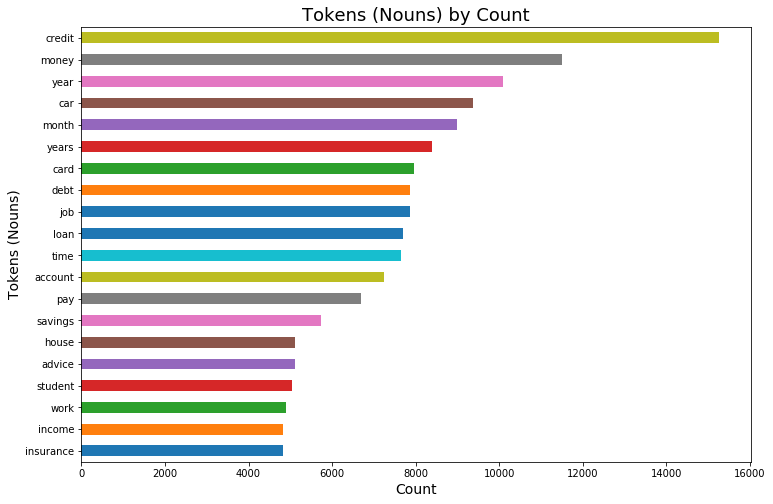

In [109]:
plt.figure(figsize=(12,8))
topic_counts.head(20)[::-1].plot(kind='barh')
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Tokens (Nouns)', fontsize = 14)
plt.title('Tokens (Nouns) by Count', fontsize = 18)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Noun Token Count.png', bbox_inches = 'tight')
plt.show()

- We see that the most common token is 'credit', not 'pay' like we had seen before. This hints at the fact that 'pay' is mainly used as a verb rather than a noun. Another interesting finding is that there are many date-based words such as 'year' and 'month'. Most likely this is because many people are describing their financial circumstances in the context of a year or several months. Other common tokens strongly suggest which topics they're part of.

### Visualizing the dependency schemes

A dependency, in the linguistic context, is a grammatical class that represents the structural relationship between words in a sentence. Here is a list of the different dependency types: https://emorynlp.github.io/nlp4j/components/dependency-parsing.html 

Let's take a look at an example of dependency schemes using the displacy feature.

In [21]:
from spacy import displacy
nlp = spacy.load('en')

# "IRS will allow employers to match their employees' student loan repayments"
title_ex = df.sort_values('upvotes', ascending = False)['title'].values[0]
doc = nlp(title_ex)
displacy.render(doc, style='dep',jupyter=True,options={'distance': 100})

In this case, the verb 'allow' could potentially be the root of the sentence (which acts as the foundation of the sentence structure).

This doesn't actually add any value to the model but it looks very interesting and overall a neat feature if you want to dive deeper into the semantics and grammatical structure of the sentences.

### What are the most common named entities?

Just to recap, named entities are real-world objects that have a name, such as a person, country, or company. spaCy is able to recognize different types of named entities in a document and can return features such as the label (ex. ORG - organization, GPE - geopolitical entity).

By observing the named entities for our dataset, we can look for key patterns such as any companies or products that come up often in the posts.

In [22]:
from collections import Counter
NE_counter = np.concatenate(df['named_entities'])
word_counter = Counter(NE_counter)
word_counter.most_common(10)

[('one', 4064),
 ('first', 3757),
 ('years', 3492),
 ('monthly', 2995),
 ('month', 2832),
 ('year', 2098),
 ('two', 1906),
 ('months', 1839),
 ('today', 1088),
 ('second', 773)]

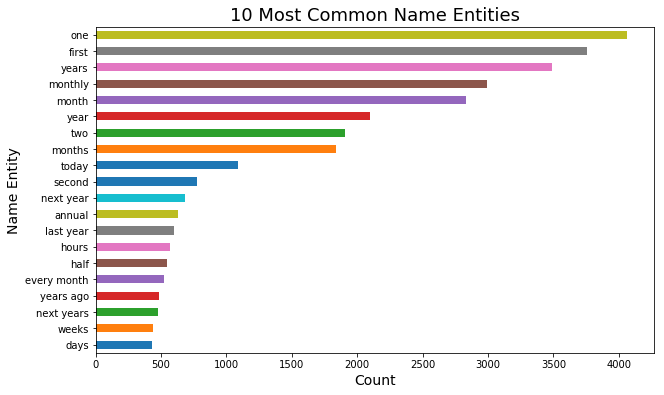

In [110]:
word_counter = Counter(NE_counter)
lst = word_counter.most_common(20)[::-1]
word_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
word_df.plot(kind = 'barh',x='Word',y='Count',figsize = (10,6), legend=None)
plt.title('10 Most Common Name Entities', fontsize = 18)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Name Entity', fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance NER.png', bbox_inches = 'tight')
plt.show()

- By far the most common types of named entity are time and date entities. This indicates that most users place a great amount of detail on the context of time when they are describing their financial issues.

### Sentiment analysis

While observing the relative sentiments of tokens is not particularly useful in determining the topics of the posts, it is nonetheless interesting to observe due to some surprising (and humorous) results. We can apply it to our text through the SentimentIntensityAnalyzer function from nltk's sentiment module.

In [24]:
# Import and initialize the SentimentIntensityAnalyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Obtain the top 1000 most polarized tokens 
top_1000 = topic_counts.sort_values(ascending=False).head(1000)
top_1000_sentiments = [sid.polarity_scores(w)['compound'] for w in top_1000.index]

# Create dataframe with a column containing the sentiment values for each token
tmp = pd.DataFrame(top_1000).assign(sentiment=top_1000_sentiments)

C:\Users\Joshua\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Let's plot the most popular positive and negative tokens.

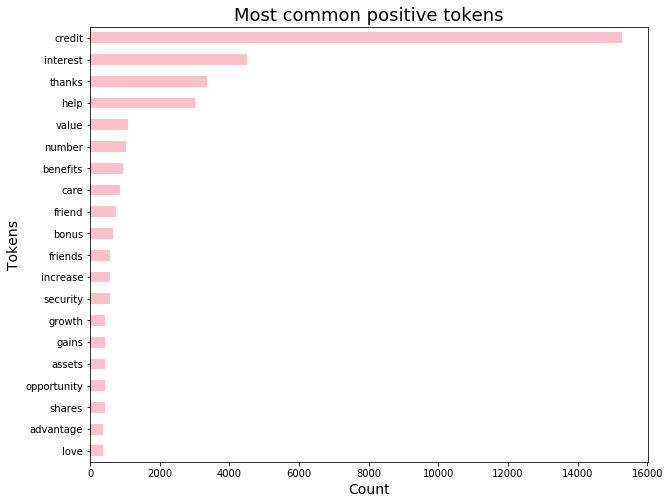

In [111]:
plt.figure(figsize=(10,8))
tmp[tmp.sentiment>0].head(20)[0][::-1].plot(kind='barh', color='pink')
plt.title('Most common positive tokens', fontsize = 18)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Tokens', fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Positive.png', bbox_inches = 'tight')
plt.show()

- 'Credit' is easily the most common positive word from the dataset, but this does beg the queston of whether or not it's truly positive in the context of the text. For example, what if they are referring to credit cards; would the word 'credit' still be considered positive? Similarly, the word 'interest' is the second most common positive word but interest in the financial context is probably negative!

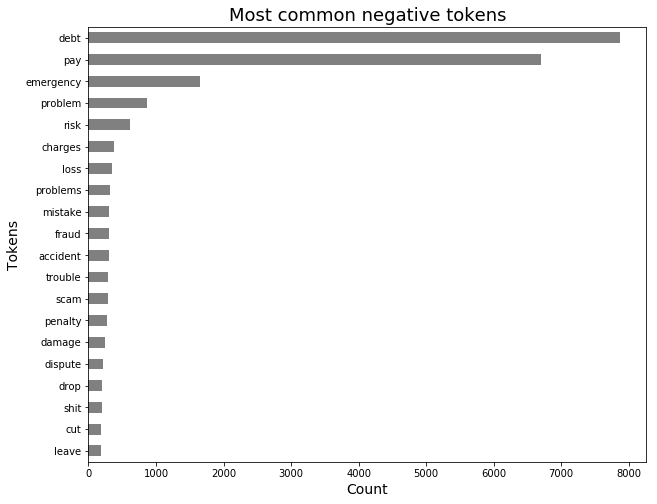

In [112]:
plt.figure(figsize=(10,8))
tmp[tmp.sentiment<0].head(20)[0][::-1].plot(kind='barh', color='grey')
plt.title('Most common negative tokens', fontsize = 18)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Tokens', fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Negative.png', bbox_inches = 'tight')
plt.show()

- On the flip side, we see that 'debt' is the most common negative word and this isn't surprising since it's also the most popular topic on /r/personalfinance. Whether or not the word 'pay' is necessarily negative can be debatable in this context since it could simply be neutral. For example, if someone has to "pay" for a cup of coffee, it's not necessarily negative since they are making a transaction to buy a drink for consumption.